Repo card metadata block was not found. Setting CardData to empty.


Number of Concepts: 208


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


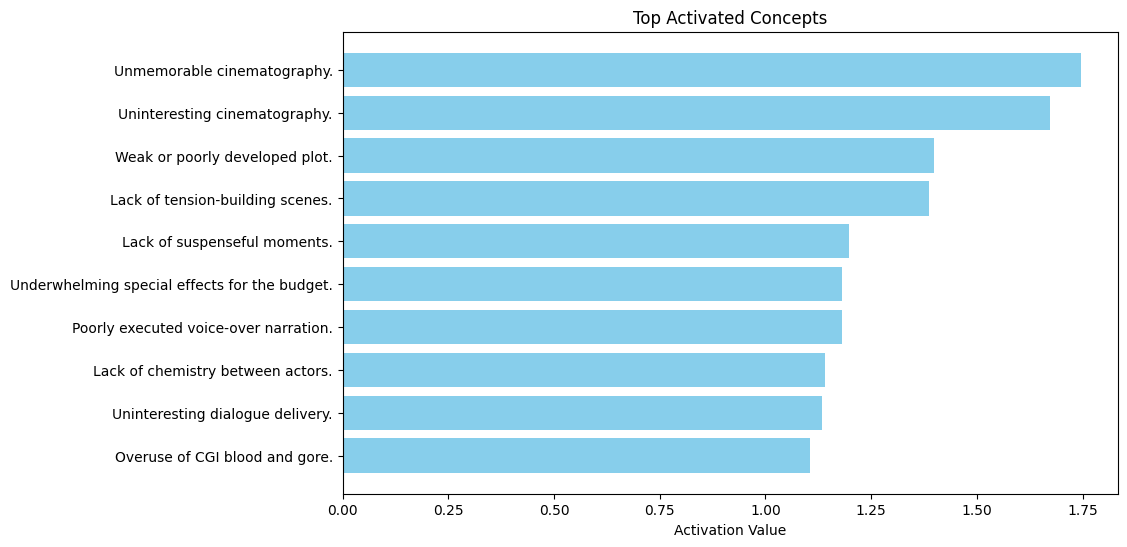

In [1]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

from datasets import load_dataset
import config as CFG
import torch
from transformers import RobertaTokenizerFast
from modules import RobertaCBL  # Your custom model (Roberta + Concept Bottleneck Layer)
from utils import normalize  # Utility function to normalize output


dataset = load_dataset("SetFit/sst2")
concept_set = CFG.concept_set["SetFit/sst2"]
# print("Concept Set:", concept_set)
print("Number of Concepts:", len(concept_set))

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define model parameters
cbl_path = "mpnet_acs/SetFit_sst2/roberta_cbm/cbl_acc_epoch_8.pt"  # Path to trained model
concept_set_size = 208  # Number of concepts
dropout_rate = 0.1  # Match the training setup

# Load tokenizer and full model
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")
full_model = RobertaCBL(concept_set_size, dropout_rate).to(device)

# Load model weights safely
state_dict = torch.load(cbl_path, map_location=device)
full_model.load_state_dict(state_dict)
full_model.eval()

# Function to preprocess input
def preprocess_input(text, tokenizer, max_length=512):
    tokens = tokenizer(text, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
    return {k: v.to(device) for k, v in tokens.items()}

# Function for inference
def predict_full_model(text, tokenizer, model):
    # Preprocess input
    tokens = preprocess_input(text, tokenizer)

    # Pass through the full model
    with torch.no_grad():
        outputs = model(tokens)  # Pass tokens through the model

        if isinstance(outputs, tuple):
            concepts = outputs[0]  # Extract the first element if it's a tuple
        else:
            concepts = outputs  # Use directly if it's already a tensor

        # apply ReLU
        concepts = torch.relu(concepts)  # Apply ReLU activation

    return concepts.cpu().numpy()




# Test the full model
sample_text = "The movie was terrible and the case was not well chosen."
concepts = predict_full_model(sample_text, tokenizer, full_model)

# print("\nConcept Activations (Full Model):")
# print(concepts)


import numpy as np

# Assuming `concepts` is the output array from your model
concept_activations = concepts[0]  # Extract the activations for the sample

# Filter for active concepts (activation > 0)
active_concepts = [(concept_set[i], concept_activations[i]) for i in range(len(concept_activations)) if concept_activations[i] > 0]

# Sort by activation value (highest to lowest)
active_concepts.sort(key=lambda x: x[1], reverse=True)

# # Display active concepts
# print("Activated Concepts (Human-Readable):")
# for concept, value in active_concepts:
#     print(f"{concept}: {value:.4f}")

import matplotlib.pyplot as plt

# Get the top N concepts (e.g., top 10)
top_n = 10
top_concepts = active_concepts[:top_n]

# Prepare data for visualization
labels, values = zip(*top_concepts)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(labels, values, color='skyblue')
plt.xlabel("Activation Value")
plt.title("Top Activated Concepts")
plt.gca().invert_yaxis()  # Highest activation at the top
plt.show()


In [7]:
import torch.nn as nn
import torch.nn.functional as F

# Define an external classification layer
class ExternalClassifier(nn.Module):
    def __init__(self, concept_dim, num_classes):
        super().__init__()
        self.classifier = nn.Linear(concept_dim, num_classes)  # Map concepts to class scores

    def forward(self, concepts):
        return self.classifier(concepts)

# Initialize the RobertaCBL model (unchanged)
concept_dim = 208  # Example concept dimension
dropout = 0.1
roberta_cbl = RobertaCBL(concept_dim, dropout).to(device)

# Initialize the external classifier
num_classes = 2  # Binary classification
classifier = ExternalClassifier(concept_dim, num_classes).to(device)

# Example: Label Mapping for sst2
label_mapping = {0: "negative", 1: "positive"}  # Update based on your dataset

# Function to classify and return human-readable label
def classify_with_label(text, tokenizer, roberta_cbl, classifier, label_mapping):
    tokens = preprocess_input(text, tokenizer)

    with torch.no_grad():
        # Get concept activations from RobertaCBL
        concept_activations = roberta_cbl(tokens)

        # Classify using the external classifier
        logits = classifier(concept_activations)
        probabilities = F.softmax(logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()

    return label_mapping[predicted_class], probabilities.cpu().numpy()

# Example usage
sample_text = "The movie was thrilling and full of suspense."
predicted_label, probabilities = classify_with_label(sample_text, tokenizer, roberta_cbl, classifier, label_mapping)

print(f"Predicted Label: {predicted_label}")
print(f"Class Probabilities: {probabilities}")


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predicted Label: positive
Class Probabilities: [[0.39277694 0.60722303]]
